<a href="https://colab.research.google.com/github/tpezzin/mpca-rp/blob/main/Generalizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalização
### Resolvendo problema de Classificação: Heart Disease

Dataset utilizado: [Heart Disease](https://www.kaggle.com/code/vijayravichandran06/heart-disease-classification-in-sklearn/data)

Baixei o dataset e salvei em meu Google Drive

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [3]:
df = pd.read_csv('/mydrive/RecPad/Aula04/heart.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
dataset = np.asarray(df)
X = dataset[:,:-1]
y = dataset[:,-1:].astype(int)

In [6]:
y = np.squeeze(np.asarray(y))

In [7]:
set(y)

{0, 1}

In [8]:
X.shape, y.shape

((303, 13), (303,))

### Testando a regressão logistica e KNN com resubstituição

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

modelo = LogisticRegression(max_iter=1000)
modelo.fit(X, y)

ypred = modelo.predict(X)

In [10]:
acuracia = accuracy_score(y, ypred)
acuracia

0.8481848184818482

In [11]:
from sklearn.neighbors import KNeighborsClassifier

#Por padrão o n_neighbors é igual a 5. Se colocarmos esse parâmetro como 1, a acurácia utilizando resubstituição daria 1. 
modelo = KNeighborsClassifier() 
modelo.fit(X, y)

ypred = modelo.predict(X)


In [12]:
acuracia = accuracy_score(y, ypred)
acuracia

0.7656765676567657

### Separando o Dataset em treino e teste, e validando os algoritmos Regressão Logistica e KNN.

In [13]:
from sklearn.model_selection import train_test_split

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_treino, y_treino)

ypred = modelo.predict(X_teste)
acuracia = accuracy_score(y_teste, ypred)
acuracia

0.8131868131868132

In [15]:
modelo = KNeighborsClassifier()
modelo.fit(X_treino, y_treino)

ypred = modelo.predict(X_teste)
acuracia = accuracy_score(y_teste, ypred)
acuracia

0.6593406593406593

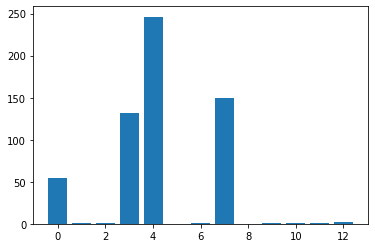

In [16]:
# Verificando a discrepância entre as características
import numpy as np
import matplotlib.pyplot as plt

plt.bar(list(range(X.shape[1])), np.mean(X, axis=0))
plt.show()

### Padronização dos dados

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

### Testando o modelo regressão logistica com validação cruzada com e sem padronização dos dados

In [18]:
from sklearn.model_selection import cross_validate

modelo = LogisticRegression(max_iter=1000)

scores = cross_validate(modelo, X, y)
semPadronizacao = np.mean(scores['test_score'])
print(f"Sem padronização: {semPadronizacao}")

Sem padronização: 0.8315300546448088


In [19]:
scores = cross_validate(modelo, X_std, y)
comPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {comPadronizacao}")

Com padronização: 0.8348633879781422


In [20]:
from sklearn.pipeline import Pipeline

modelo = Pipeline([
    ("padronizacao", scaler),
    ("classificador", LogisticRegression())
])

scores = cross_validate(modelo, X, y)
aninhado = np.mean(scores['test_score'])
print(f"Aninhado: {aninhado}")

Aninhado: 0.8348633879781422


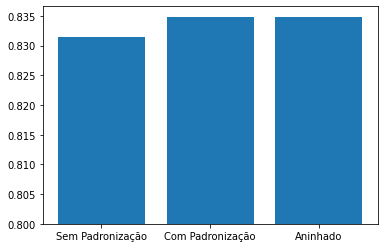

In [21]:
colunas = ["Sem Padronização", "Com Padronização", "Aninhado"]
plt.bar(colunas, np.array([semPadronizacao, comPadronizacao, aninhado])-0.8, bottom=0.8)
plt.show()

### Testando o modelo KNN com validação cruzada com e sem padronização dos dados

In [22]:
from sklearn.model_selection import cross_validate

modelo = KNeighborsClassifier()

scores = cross_validate(modelo, X, y)
semPadronizacao = np.mean(scores['test_score'])
print(f"Sem padronização: {semPadronizacao}")

Sem padronização: 0.643879781420765


In [23]:
scores = cross_validate(modelo, X_std, y)
comPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {comPadronizacao}")

Com padronização: 0.8118579234972678


In [24]:
from sklearn.pipeline import Pipeline

modelo = Pipeline([
    ("padronizacao", scaler),
    ("classificador", KNeighborsClassifier())
])

scores = cross_validate(modelo, X, y)
aninhado = np.mean(scores['test_score'])
print(f"Aninhado: {aninhado}")

Aninhado: 0.8150819672131148


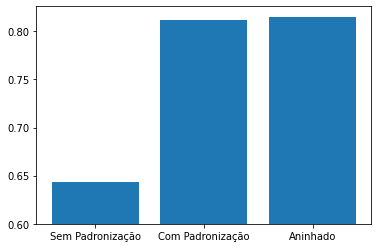

In [25]:
colunas = ["Sem Padronização", "Com Padronização", "Aninhado"]
plt.bar(colunas, np.array([semPadronizacao, comPadronizacao, aninhado])-0.6, bottom=0.6)
plt.show()

### Pipeline dentro do Grid Search com padronização dos dados testando a variação 3, 5 e 7 do parâmetro n_neighbors do KNeighborsClassifier

In [26]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("padronizacao", scaler),
    ("knn", KNeighborsClassifier())
])

parametros = {'knn__n_neighbors': [3,5,7]}
cv = RepeatedKFold(n_splits=5, n_repeats=10)
modelo = GridSearchCV(pipeline, parametros, scoring='accuracy', cv=cv)

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
comPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {comPadronizacao}")


Com padronização: 0.821639344262295


### Pipeline dentro do Grid Search sem padronização dos dados testando a variação 3, 5 e 7 do parâmetro n_neighbors do KNeighborsClassifier

In [27]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("knn", KNeighborsClassifier())
])

parametros = {'knn__n_neighbors': [3,5,7]}
cv = RepeatedKFold(n_splits=5, n_repeats=10)
modelo = GridSearchCV(pipeline, parametros, scoring='accuracy', cv=cv)

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
semPadronizacao = np.mean(scores['test_score'])
print(f"Sem padronização: {semPadronizacao}")

Sem padronização: 0.6504918032786885


### Pipeline dentro do Grid Search com padronização dos dados testando a variação 'newton-cg', 'lbfgs', 'liblinear', 'sag' e 'saga' do parâmetro solver da regressão logistica.

In [28]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("padronizacao", scaler),
    ("lr", LogisticRegression())
])

parametros = {'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
cv = RepeatedKFold(n_splits=5, n_repeats=10)
modelo = GridSearchCV(pipeline, parametros, scoring='accuracy', cv=cv)

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
comPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {comPadronizacao}")

Com padronização: 0.8348633879781422


### Pipeline dentro do Grid Search sem padronização dos dados testando a variação 'newton-cg', 'lbfgs', 'liblinear', 'sag' e 'saga' do parâmetro solver da regressão logistica.

In [29]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("lr", LogisticRegression(max_iter=10000))
])

parametros = {'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
cv = RepeatedKFold(n_splits=5, n_repeats=10)
modelo = GridSearchCV(pipeline, parametros, scoring='accuracy', cv=cv)

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
semPadronizacao = np.mean(scores['test_score'])
print(f"Sem padronização: {semPadronizacao}")

Sem padronização: 0.828087431693989


### Grid Search dentro do Pipeline com padronização dos dados testando a variação 3, 5 e 7 do parâmetro n_neighbors do KNeighborsClassifier

In [30]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

parametros = {'n_neighbors': [3,5,7]}

cv = RepeatedKFold(n_splits=5, n_repeats=10)
GridSearchKNN = GridSearchCV(KNeighborsClassifier(), parametros, scoring='accuracy', cv=cv)

modelo = Pipeline([
    ("padronizacao", scaler),
    ("gsknn", GridSearchKNN)
])

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
comPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {comPadronizacao}")

Com padronização: 0.8314754098360655


### Grid Search dentro do Pipeline sem padronização dos dados testando a variação 3, 5 e 7 do parâmetro n_neighbors do KNeighborsClassifier

In [31]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

parametros = {'n_neighbors': [3,5,7]}

cv = RepeatedKFold(n_splits=5, n_repeats=10)
GridSearchKNN = GridSearchCV(KNeighborsClassifier(), parametros, scoring='accuracy', cv=cv)

modelo = Pipeline([
    ("gsknn", GridSearchKNN)
])

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
semPadronizacao = np.mean(scores['test_score'])
print(f"Sem padronização: {semPadronizacao}")

Sem padronização: 0.6240983606557378


### Grid Search dentro do Pipeline com padronização dos dados testando a variação 'newton-cg', 'lbfgs', 'liblinear', 'sag' e 'saga' do parâmetro solver da regressão logistica.

In [32]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

parametros = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

cv = RepeatedKFold(n_splits=5, n_repeats=10)
GridSearchKNN = GridSearchCV(LogisticRegression(), parametros, scoring='accuracy', cv=cv)

modelo = Pipeline([
    ("padronizacao", scaler),
    ("gsknn", GridSearchKNN)
])

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
comPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {comPadronizacao}")

Com padronização: 0.8348633879781422


### Grid Search dentro do Pipeline sem padronização dos dados testando a variação 'newton-cg', 'lbfgs', 'liblinear', 'sag' e 'saga' do parâmetro solver da regressão logistica.

In [33]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline

parametros = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

cv = RepeatedKFold(n_splits=5, n_repeats=10)
GridSearchKNN = GridSearchCV(LogisticRegression(max_iter=10000), parametros, scoring='accuracy', cv=cv)

modelo = Pipeline([
    ("gsknn", GridSearchKNN)
])

scores = cross_validate(modelo, X, y, scoring=make_scorer(accuracy_score, greater_is_better=True))
semPadronizacao = np.mean(scores['test_score'])
print(f"Com padronização: {semPadronizacao}")

Com padronização: 0.821584699453552
